In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import os
import sys
import time
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
K.set_epsilon(1e-08)
print('[INFO] Using keras {0}'.format(keras.__version__))

import tensorflow as tf
print('[INFO] Using tensorflow {0}'.format(tf.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

#import pandas as pd
#import statsmodels

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# ______________________________________________________________________________
# Globals
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.12.npz'


[INFO] Using numpy 1.12.1


Using TensorFlow backend.


[INFO] Using keras 2.0.5
[INFO] Using tensorflow 1.1.0
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3646057, 76)
[INFO] Loaded the parameters with shape (3646057, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 6) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_ring  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_fr    = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_mask  = self.x_copy[:, nlayers*5:nlayers*6].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*6:nlayers*7]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis]
      self.x_zone         = self.x_road[:, 1][:, np.newaxis]
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # adjust by hand
        self.x_phi   *= 0.000991  # GE1/1 dphi linear correlation with q/pT
        self.x_theta *= (1/12.)   # 12 integer theta units
        self.x_bend  *= 0.188082  # ME1/2 bend linear correlation with q/pT
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        self.x_ring[x_ring_tmp] = 0  # ring 1,4 -> 0
        self.x_ring[~x_ring_tmp] = 1 # ring 2,3 -> 1
        #self.x_fr     = self.x_fr
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        theta_cuts   *= (1/12.)   # 12 integer theta units
        assert(len(theta_cuts) == nlayers)
        x_theta_tmp = np.abs(self.x_theta) > theta_cuts
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_ring [x_theta_tmp] = np.nan
      self.x_fr   [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness -= 6.  # scaled to [-1,1]
      self.x_straightness /= 6.
      self.x_zone         -= 0.  # scaled to [0,1]
      self.x_zone         /= 5.
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_ring, self.x_fr, self.x_straightness, self.x_zone, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


[INFO] Using 68 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[ 0.22594799  0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.026757   -0.011892   ...,  1.          1.          1.        ]
 [ 0.          0.007928    0.003964   ...,  1.          1.          1.        ]
 ..., 
 [ 0.31216499  0.          0.         ...,  1.          1.          1.        ]
 [ 0.095136    0.         -0.031712   ...,  1.          1.          1.        ]
 [ 0.15955099  0.         -0.055496   ...,  1.          1.          1.        ]] [ 0.45731288  0.14871465  0.01238597 ...,  0.37654495  0.13762507
  0.43144876] [ 3.28656435  1.74357319  1.06192982 ...,  2.88272476  1.68812537
  3.15724373]
[ -1.13775465e-03  -1.21311634e-03  -2.28543929e-03  -2.45982758e-03
  -2.64636218e-03  -1.21401867e-03  -8.58638552e-04  -2.24672235e-03
  -2.14490993e-03  -8.11390462e-04  -9.54931311e-04   0.00000000e+00
   7.06632361e-02   2.37259362e-02   4.39805817e-03  -2.49726456e-02
  -2.73069106e-02   1.42409028e-02   1.46502145e-02  -2.97896825e-02
  -1.15

In [6]:
#### Create a model ####

# See https://keras.io/models/about-keras-models/
#     https://keras.io/layers/about-keras-layers/
# for all kinds of things you can do with Keras

# Define model
#model = Sequential()
#model.add(Dense(8, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_normal'))
#model.add(Dense(4, activation='tanh', kernel_initializer='glorot_normal'))
#model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

#model = Sequential()
#model.add(Dense(64, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
#model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
#model.add(Dense(8, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
#model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

model = Sequential()
model.add(Dense(64, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
#model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
#model.add(Dropout(0.2))
model.add(Dense(16, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

# Set loss and optimizer
def huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

# from https://arogozhnikov.github.io/hep_ml/_modules/hep_ml/nnet.html#smooth_huber_loss
def smooth_huber_loss(y_true, y_pred):
  x = K.abs(y_true - y_pred)
  return K.mean(x + K.log(1 + K.exp(-2 * x)), axis=-1)

def pseudo_huber_loss(y_true, y_pred, delta=1.0):
  delta2 = delta * delta
  x = delta2 * (K.sqrt(1 + K.square(y_true - y_pred)/delta2) - 1)
  return K.mean(x, axis=-1)

# Learning rate decay by epoch number
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
  if (epoch % 10) == 0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr*0.95)
    print("lr changed to {}".format(lr*0.95))
  return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(lr_schedule)


adam = optimizers.Adam(lr=0.001)
#adam = optimizers.Adam(lr=0.005)
#adam = optimizers.Adam(lr=0.001, amsgrad=True)
#adam = optimizers.Adam(lr=0.0001, decay=0.00001,)
#rmsprop = optimizers.RMSprop(lr=0.0001, decay=0.00001,)

# Compile
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc', 'mse', 'mae'])
#model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc', 'mse', 'mae'])
#model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['acc', 'mse', 'mae'])
model.compile(loss=huber_loss, optimizer=adam, metrics=['acc', 'mse', 'mae'])
#model.compile(loss=huber_loss, optimizer=rmsprop, metrics=['acc', 'mse', 'mae'])
#model.compile(loss='logcosh', optimizer='adam', metrics=['acc', 'mse', 'mae'])

In [ ]:
#### Training ####

#history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=1000, verbose=1)

# The webpage can become very unresponsive when you train with a large dataset with the above comment.
# So I do the following instead.
# See issue https://github.com/jupyter/notebook/issues/1474

start_time = time.time()
old_stdout = sys.stdout
sys.stdout = open('keras_output.txt', 'w')
history = model.fit(x_train, y_train, epochs=20, validation_split=0.1, batch_size=256, verbose=1)
#history = model.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=256, callbacks=[lr_decay], verbose=1)
#history = model.fit(x_train, y_train, epochs=400, validation_split=0.1, batch_size=256, callbacks=[lr_decay], verbose=0)
#history = model.fit(x_train, y_train, sample_weight=w_train, epochs=40, validation_split=0.1, batch_size=256, verbose=1)
#history = model.fit(x_train, y_train, sample_weight=w_train, epochs=200, validation_split=0.1, batch_size=256, verbose=0)
sys.stdout.close()
sys.stdout = old_stdout
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))

# Store model to file
model.summary()
model.save('model.h5')
model.save_weights('model_weights.h5')

# Store model to json
import json
with open('model.json', 'w') as outfile:
  json.dump(model.to_json(), outfile)
  
print('[INFO] Model is saved as model.h5, model.json and model_weights.h5')

In [ ]:
#### Evaluation using Keras internal tool ####

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)
#loss_and_metrics = model.evaluate(x_test, y_test, sample_weight=w_test, batch_size=1000)
print('[INFO] loss and metrics: {0}'.format(loss_and_metrics))

## Accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Squared Error
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Absolute Error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### Application ####

from keras.models import load_model
import ROOT

# Load model
loaded_model = load_model('model.h5', custom_objects={'huber_loss': huber_loss})
loaded_model.load_weights('model_weights.h5')

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1 = ROOT.TH1F("h1", "h1", 300, -0.3, 0.3)
h2a = ROOT.TH2F("h2a", "h2a", 100, -0.5, 0.5, 300, -0.3, 0.3)
h2b = ROOT.TH2F("h2b", "h2b", 100, -0.5, 0.5, 300, -0.5, 0.5)
h2c = ROOT.TH2F("h2c", "h2c", 100, -0.5, 0.5, 400, -2, 2)
h2d = ROOT.TH2F("h2d", "h2d", 100, -0.5, 0.5, 400, -2, 2)

nentries_test = x_test.shape[0]/10
#nentries_test = 100000

y_test_meas = loaded_model.predict(x_test[:nentries_test, :])


# Loop over events
for i in xrange(nentries_test):
  y_true = y_test[i]
  y_meas = y_test_meas[i]
  h1.Fill(y_meas - y_true)
  h2a.Fill(y_true, y_meas - y_true) 
  h2b.Fill(y_true, y_meas)
  h2c.Fill(y_true, (y_meas - y_true)/abs(y_true))
  h2d.Fill(abs(y_true), (abs(y_meas) - abs(y_true))/abs(y_true)) 

# Draw
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

print h1.GetEntries(), h1.GetMean(), h1.GetRMS()

In [ ]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

In [ ]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

In [ ]:
c = ROOT.TCanvas()
h2c.Draw("COLZ")
c.Draw()

In [ ]:
c = ROOT.TCanvas()
h2d.SetStats(0)
h2d.SetTitle("")
h2d.GetXaxis().SetTitle("gen 1/p_{T} [1/GeV]")
h2d.GetYaxis().SetTitle("#Delta(p_{T})/p_{T}")
h2d.GetXaxis().SetRangeUser(0, 0.5)
h2d.GetYaxis().SetRangeUser(-1, 2)
h2d.Draw("COLZ")
c.Draw()

In [ ]:
c = ROOT.TCanvas()

hname = "h2d"
h = h2d.Clone("h2d_clone")
h.Draw("COLZ")
#gPad.Print(hname+".png")
#h.RebinX(2)

h_pfx = h.ProfileX(hname+"_pfx", 1, -1, "s")
h_pfx.SetMaximum(1.2)
h_pfx.SetMinimum(-0.2)
h_pfx.Draw()
#h_pfx.Fit("pol1", "", "", 0.025, 0.2499)
#gPad.Print(h_pfx.GetName()+".png")
#

if True:
  # Apply gaussian fits
  gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr1_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  for i in xrange(h.GetNbinsX()):
    h_py = h.ProjectionY("_py", i+1, i+1)
    if h_py.Integral() < 15:  continue
    #r = h_py.Fit("gaus", "SNQ")
    r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*8, h_py.GetMean() + 0.04*8)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
    gr1.SetPointError(i, 0, 0, sigma, sigma)
    gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    gr1_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), mean)
    gr1_aspt.SetPointError(i, 0, 0, sigma, sigma)
    gr2_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2_aspt.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
  #
  hname1 = hname
  h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  h_pfx.Draw()
  gr1.Draw("p")
  #gr1.Fit("pol1", "", "", 0.025, 0.2499)
  #gPad.Print(h_pfx.GetName()+".png")
  #
  hname2 = hname
  h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetMaximum(1)
  h_pfx.SetMinimum(0)
  h_pfx.Draw()
  gr2.Draw("p")
  #gr2.Fit("pol1", "", "", 0.025, 0.2499)
  #gPad.Print(h_pfx.GetName()+".png")
  #
  hname1 = hname
  h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetBins(50, 0, 50)
  h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
  h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} bias")
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  h_pfx.Draw()
  gr1_aspt.Draw("p")
  #gr1_aspt.Fit("pol1", "", "", 0.025, 0.2499)
  #ROOT.gPad.SetLogx(1)
  #ROOT.gPad.Print(h_pfx.GetName()+".png")
  #ROOT.gPad.SetLogx(0)
  #
  hname2 = hname
  h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetStats(0)
  h_pfx.SetBins(50, 0, 50)
  h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
  h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} resolution")
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  #h_pfx.SetMaximum(0.1)
  #h_pfx.SetMinimum(-0.01)
  h_pfx.Draw()
  gr2_aspt.Draw("p")
  #gr2_aspt.Fit("pol1", "", "", 0.025, 0.2499)
  ROOT.gPad.SetLogx(1)
  #ROOT.gPad.Print(h_pfx.GetName()+".png")
  #ROOT.gPad.SetLogx(0)
    
c.Draw()

In [ ]:
c = ROOT.TCanvas()

hname = "h2b"
h = h2b.Clone("h2b_clone")

if True:
  gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr3 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  for i in xrange(h.GetNbinsX()):
    h_py = h.ProjectionY("_py", i+1, i+1)
    if h_py.Integral() < 15:  continue
    #r = h_py.Fit("gaus", "SNQ")
    r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*5, h_py.GetMean() + 0.04*5)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    #mean, sigma, meanErr, sigmaErr = h_py.GetMean(), h_py.GetRMS(), 0, 0  #FIXME
    gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
    gr1.SetPointError(i, 0, 0, sigma, sigma)
    gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    #print h_py.Integral(), h_py.Integral(h_py.FindBin(mean-sigma), h_py.FindBin(mean+sigma))
    loss = 1.0 - h_py.Integral(h_py.FindBin(mean-sigma), h_py.FindBin(mean+sigma)) / h_py.Integral()
    gr3.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), loss)
    gr3.SetPointError(i, 0, 0, 0, 0)
  #
  #gr1.Draw("ap")
  #gr2.Draw("ap")
  gr3.Draw("ap")

c.Draw()

In [ ]:
########################## PLEASE IGNORE

In [7]:
#### Training Functions ####

from keras import callbacks as cbks

def _make_batches(size, batch_size):
    """Returns a list of batch indices (tuples of indices).
    # Arguments
        size: Integer, total size of the data to slice into batches.
        batch_size: Integer, batch size.
    # Returns
        A list of tuples of array indices.
    """
    num_batches = (size + batch_size - 1) // batch_size  # round up
    return [(i * batch_size, min(size, (i + 1) * batch_size))
            for i in range(num_batches)]

def _slice_arrays(arrays, start=None, stop=None):
    """Slice an array or list of arrays.
    This takes an array-like, or a list of
    array-likes, and outputs:
        - arrays[start:stop] if `arrays` is an array-like
        - [x[start:stop] for x in arrays] if `arrays` is a list
    Can also work on list/array of indices: `_slice_arrays(x, indices)`
    # Arguments
        arrays: Single array or list of arrays.
        start: can be an integer index (start index)
            or a list/array of indices
        stop: integer (stop index); should be None if
            `start` was a list.
    # Returns
        A slice of the array(s).
    """
    if arrays is None:
        return [None]
    elif isinstance(arrays, list):
        if hasattr(start, '__len__'):
            # hdf5 datasets only support list objects as indices
            if hasattr(start, 'shape'):
                start = start.tolist()
            return [None if x is None else x[start] for x in arrays]
        else:
            return [None if x is None else x[start:stop] for x in arrays]
    else:
        if hasattr(start, '__len__'):
            if hasattr(start, 'shape'):
                start = start.tolist()
            return arrays[start]
        elif hasattr(start, '__getitem__'):
            return arrays[start:stop]
        else:
            return [None]

def _batch_shuffle(index_array, batch_size):
    """Shuffles an array in a batch-wise fashion.
    Useful for shuffling HDF5 arrays
    (where one cannot access arbitrary indices).
    # Arguments
        index_array: array of indices to be shuffled.
        batch_size: integer.
    # Returns
        The `index_array` array, shuffled in a batch-wise fashion.
    """
    batch_count = int(len(index_array) / batch_size)
    # to reshape we need to be cleanly divisible by batch size
    # we stash extra items and reappend them after shuffling
    last_batch = index_array[batch_count * batch_size:]
    index_array = index_array[:batch_count * batch_size]
    index_array = index_array.reshape((batch_count, batch_size))
    np.random.shuffle(index_array)
    index_array = index_array.flatten()
    return np.append(index_array, last_batch)

def train(model, x, y, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0., shuffle=True, sample_weight=None):
  
  out_labels = ['loss', 'acc', 'mean_squared_error', 'mean_absolute_error']
  callback_metrics = out_labels + ['val_' + n for n in out_labels]
  history = cbks.History()
  callbacks = [cbks.BaseLogger()] + (callbacks or []) + [history]
  if verbose:
    callbacks += [cbks.ProgbarLogger()]
  callbacks = cbks.CallbackList(callbacks)
  callback_model = model
  
  x = [x]
  y = [y]
  sample_weights = [sample_weight]
  
  val_x = [None]
  val_y = [None]
  val_sample_weights = [None]
  
  # from fit() in training.py
  do_validation = False
  if validation_split and 0. < validation_split < 1.:
    do_validation = True
    split_at = int(x[0].shape[0] * (1. - validation_split))
    x, val_x = (_slice_arrays(x, 0, split_at), _slice_arrays(x, split_at))
    y, val_y = (_slice_arrays(y, 0, split_at), _slice_arrays(y, split_at))
    sample_weights, val_sample_weights = (_slice_arrays(sample_weights, 0, split_at), _slice_arrays(sample_weights, split_at))

  ins = x + y + sample_weights
  val_ins = val_x + val_y + val_sample_weights

  # from _fit_loop() in training.py
  num_train_samples = x[0].shape[0]
  index_array = np.arange(num_train_samples)
  num_test_samples = val_x[0].shape[0]
  val_index_array = np.arange(num_test_samples)
  
  callbacks.set_model(callback_model)
  callbacks.set_params({
      'batch_size': batch_size,
      'epochs': epochs,
      'samples': num_train_samples,
      'verbose': verbose,
      'do_validation': do_validation,
      'metrics': callback_metrics or [],
  })
  callbacks.on_train_begin()
  callback_model.stop_training = False
  for cbk in callbacks:
      cbk.validation_data = val_ins
  
  # Loop over epochs
  for epoch in xrange(epochs):
    callbacks.on_epoch_begin(epoch)
    if shuffle:
      np.random.shuffle(index_array)
      #np.random.shuffle(val_index_array)
    
    batches = _make_batches(num_train_samples, batch_size)
    epoch_logs = {}
    
    # Loop over batches
    for batch_index, (batch_start, batch_end) in enumerate(batches):
      batch_ids = index_array[batch_start:batch_end]
      ins_batch = _slice_arrays(ins, batch_ids)
      
      batch_logs = {}
      batch_logs['batch'] = batch_index
      batch_logs['size'] = len(batch_ids)
      callbacks.on_batch_begin(batch_index, batch_logs)
      
      outs = model.train_on_batch(ins_batch[0], ins_batch[1], sample_weight=ins_batch[2], class_weight=None)
      if not isinstance(outs, list):
        outs = [outs]
      for l, o in zip(out_labels, outs):
        batch_logs[l] = o
      
      callbacks.on_batch_end(batch_index, batch_logs)
      if callback_model.stop_training:
        break
      
      if batch_index == len(batches) - 1:  # Last batch.
        if do_validation:
          # from _test_loop in training.py
          val_batches = _make_batches(num_test_samples, batch_size)
          val_outs = []
          for val_batch_index, (val_batch_start, val_batch_end) in enumerate(val_batches):
            val_batch_ids = val_index_array[val_batch_start:val_batch_end]
            val_ins_batch = _slice_arrays(val_ins, val_batch_ids)
          
            val_batch_outs = model.test_on_batch(val_ins_batch[0], val_ins_batch[1], sample_weight=val_ins_batch[2])
            if isinstance(val_batch_outs, list):
              if val_batch_index == 0:
                for i, val_batch_out in enumerate(val_batch_outs):
                  val_outs.append(0.)
              for i, val_batch_out in enumerate(val_batch_outs):
                val_outs[i] += val_batch_out * len(val_batch_ids)
            else:
              if val_batch_index == 0:
                val_outs.append(0.)
              val_outs[0] += val_batch_outs * len(val_batch_ids)
            
          if not isinstance(val_outs, list):
            val_outs = [val_outs]
          # Same labels assumed.
          for l, o in zip(out_labels, val_outs):
            o /= num_test_samples
            epoch_logs['val_' + l] = o
            
    callbacks.on_epoch_end(epoch, epoch_logs)
    if callback_model.stop_training:
      break

  callbacks.on_train_end()
  return history

In [8]:
#### Training ####

#history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=1000, verbose=1)

# The webpage can become very unresponsive when you train with a large dataset with the above comment.
# So I do the following instead.
# See issue https://github.com/jupyter/notebook/issues/1474

start_time = time.time()
old_stdout = sys.stdout
sys.stdout = open('keras_output.txt', 'w')
#history = model.fit(x_train, y_train, epochs=5, validation_split=0.1, batch_size=256, verbose=1)
history = train(model, x_train, y_train, epochs=5, validation_split=0.1, batch_size=256, verbose=1)
sys.stdout.close()
sys.stdout = old_stdout
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))

# Store model to file
model.summary()
model.save('model.h5')
model.save_weights('model_weights.h5')

# Store model to json
import json
with open('model.json', 'w') as outfile:
  json.dump(model.to_json(), outfile)
  
print('[INFO] Model is saved as model.h5, model.json and model_weights.h5')

[INFO] Time elapsed: 144.827196121 sec
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4416      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________
[INFO] Model is saved as model.h5, model.json and model_weights.h5


1457000/1458423 [============================>.] - ETA: 0s

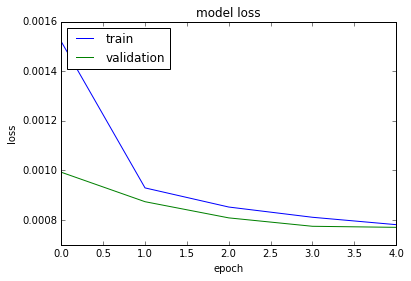

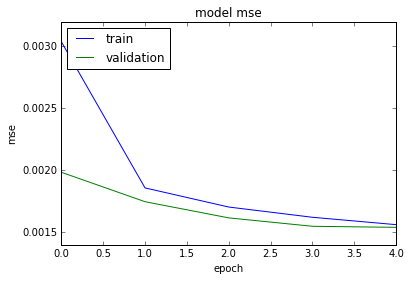

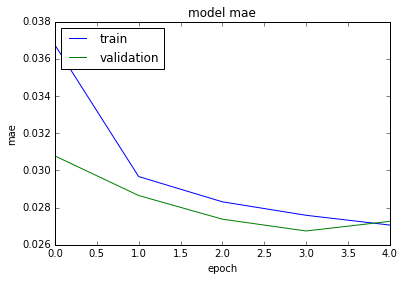

In [9]:
#### Evaluation using Keras internal tool ####

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)
#loss_and_metrics = model.evaluate(x_test, y_test, sample_weight=w_test, batch_size=1000)
print('[INFO] loss and metrics: {0}'.format(loss_and_metrics))

## Accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Squared Error
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Absolute Error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
########################## PLEASE IGNORE

In [11]:
from keras.engine import Layer
from keras import backend as K

class MyLeakyReLU(Layer):
    """Leaky version of a Rectified Linear Unit.
    It allows a small gradient when the unit is not active:
    `f(x) = alpha * x for x < 0`,
    `f(x) = x for x >= 0`.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        alpha: float >= 0. Negative slope coefficient.
    # References
        - [Rectifier Nonlinearities Improve Neural Network Acoustic Models](https://web.stanford.edu/~awni/papers/relu_hybrid_icml2013_final.pdf)
    """

    def __init__(self, alpha=0.3, **kwargs):
        super(MyLeakyReLU, self).__init__(**kwargs)
        self.supports_masking = True
        if isinstance(alpha, dict):
            self.alpha = K.cast_to_floatx(alpha['value'])
        else:
            self.alpha = K.cast_to_floatx(alpha)

    def call(self, inputs):
        return K.relu(inputs, alpha=self.alpha)

    def get_config(self):
        config = {'alpha': float(self.alpha)}
        base_config = super(MyLeakyReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


In [12]:
class MyTriggerV1(object):
  
  def __init__(self):
    pass

  def get_trigger_pt(self, y_meas):
    pt = np.abs(1.0/y_meas)
    pt_clipped = np.clip(pt, 3., 60.)
    pt = pt * (1.0 + (0.08813 + 0.009504 * pt_clipped) * 1.28155)  # erf(1.28155/sqrt(2)) = 0.8 [90% upper limit from -1 to -1]
    return pt
  
  def pass_trigger(self, x, ndof, y_meas, y_discr):
    trk_mode = 0
    x_mode_vars = x[nlayers*5+3:nlayers*5+8].astype(np.bool)  # convert to booleans
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))

    pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
    def find_pt_bin(pt):
      ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
      ipt = np.clip(ipt, 0, len(pt_bins)-2)
      return ipt
    def find_road_quality(ipt):
      best_ipt = find_pt_bin(0.)
      return best_ipt - abs(ipt - best_ipt)

    ipt1 = (x[nlayers*5+0:nlayers*5+1] * 6 + 6).astype(np.int32)
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_road_quality(ipt1)
    quality2 = find_road_quality(ipt2)
    
    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > 14.:
        if ndof <= 3:
          #trigger = (y_discr > 0.5)
          trigger = (y_discr > 0.8)
          #trigger = (y_discr > 0.95)
        else:
          trigger = (y_discr > 0.5393)
          #trigger = (y_discr > 0.95)
      else:
        trigger = True
    else:
      trigger = False

    return trigger

In [13]:
#### Application ####

from keras.models import load_model
import ROOT

#model = 'model.12.h5'
#model_weights = 'model_weights.12.h5'
#model_discr = 'model_discr.12.h5'
#model_discr_weights = 'model_discr_weights.12.h5'

model = 'model.h5'
model_weights = 'model_weights.h5'
model_discr = 'model_discr.h5'
model_discr_weights = 'model_discr_weights.h5'

# Load model
loaded_model = load_model(model, custom_objects={'huber_loss': huber_loss})
loaded_model.load_weights(model_weights)

loaded_model_discr = load_model(model_discr, custom_objects={'MyLeakyReLU': MyLeakyReLU})
loaded_model_discr.load_weights(model_discr_weights)

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetMarkerStyle(1)
ROOT.gStyle.SetEndErrorSize(0)
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

nentries_test = x_test.shape[0]/6
#nentries_test = 100000

y_test_meas = loaded_model.predict(x_test[:nentries_test, :])
y_test_discr = loaded_model_discr.predict(x_test[:nentries_test, :])

mytrigger = MyTriggerV1()

histograms = {}


Welcome to JupyROOT 6.10/05


In [14]:
#### Efficiency ####

from rootpy.plotting import Hist, Efficiency

eff_pt_bins = (0., 0.5, 1., 2., 3., 4., 5., 6., 8., 10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 35., 40., 45., 50., 60., 80., 120.)

hname = "x_eff_vs_genpt_l1pt20_denom"
h1c_denom = Hist(eff_pt_bins, name=hname, title="; gen p_{T} [GeV]", type='F')
hname = "x_eff_vs_genpt_l1pt20_numer"
h1c_numer = Hist(eff_pt_bins, name=hname, title="; gen p_{T} [GeV]", type='F')

# Loop over events
for x, ndof, y_meas, y_discr, y_true in zip(x_test, x_test, y_test_meas, y_test_discr, y_test):

  ndof = 4  #FIXME
  
  pt = mytrigger.get_trigger_pt(y_meas)
  
  trigger = mytrigger.pass_trigger(x, ndof, y_meas, y_discr)
  trigger = trigger and (pt > 20.)
  
  pt_true = np.abs(1.0/y_true)
  
  h1c_denom.fill(pt_true)
  if trigger:
    h1c_numer.fill(pt_true)

h1c_eff = Efficiency(h1c_numer, h1c_denom)
h1c_eff.SetStatisticOption(0)  # kFCP
h1c_eff.SetConfidenceLevel(0.682689492137)  # one sigma
h1c_eff.SetMarkerStyle(1)
h1c_eff.SetMarkerColor(800)  # kOrange
h1c_eff.SetLineColor(800)  # kOrange
h1c_eff.SetLineWidth(2)
h1c_eff.SetDirectory(0)
histograms['h1c_numer'] = h1c_numer
histograms['h1c_denom'] = h1c_denom
histograms['h1c_eff'] = h1c_eff

# Add corrections
if False:
  nbinsx = h1c_eff.GetTotalHistogram().GetNbinsX()
  corrections = [0.0, 0.0, 0.0, 2.5596844660416443e-05, 9.071900979369844e-05, -0.00025407866698875234, 3.9318943372533294e-05, 0.00046750609322471475, -0.0012868531325132167, -0.0017629378199139414, -0.003412967281340079, -1.859263302672609e-05, -0.0027697063960877566, -0.011912089953303617, -0.012565904385017701, -0.01502952024543791, -0.007091832957321742, -0.011625792518549893, -0.017156862745097978, -0.007722007722007707, -0.008966446308134701, -0.00857140366324638, -0.021269462895507463, -0.009598486441034226, -0.01485925792486198, -0.010991760558270336]
  assert(len(corrections) == nbinsx)
  for b in xrange(1,nbinsx+1):
    old_eff = h1c_eff.GetEfficiency(b)
    new_eff = old_eff + corrections[b-1]
    h1c_eff.GetPassedHistogram().SetBinContent(b, h1c_eff.GetTotalHistogram().GetBinContent(b) * new_eff)

[0.0, 0.0, 0.0, -3.289861677326932e-06, -2.6533528723760437e-05, -0.0007123213064663557, -0.0006023423761164709, -0.0025679535949507896, -0.007799764020567774, -0.010196947393654537, 0.004319398191281021, 0.07981245277352028, 0.1607283924632278, 0.16492781238363396, 0.12717391936655598, 0.10835997430362054, 0.07032376657702044, 0.05193066454703488, 0.02941176470588236, 0.030888030888030937, 0.019089665916314225, 0.019317042551893038, 0.001967716591672053, 0.010119823418120677, -0.0010507946731915796, 0.007373712352657158]


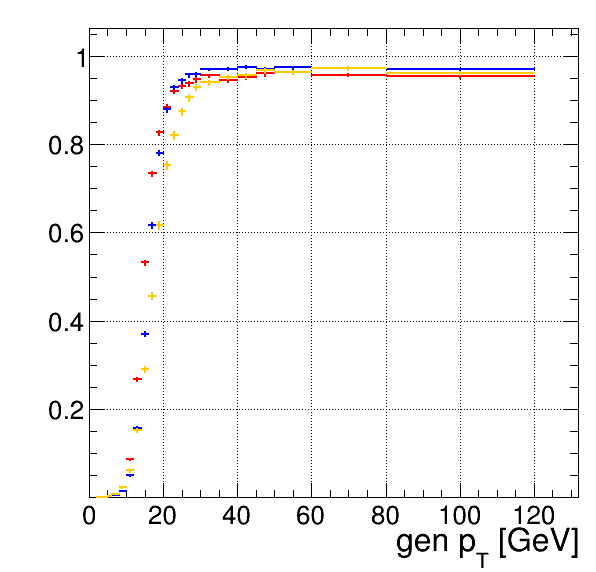

In [15]:
#### Efficiency ####

infile1 = ROOT.TFile.Open("emtf_eff_vs_genpt_l1pt20.root")
frame = infile1.Get("emtf_eff_vs_genpt_l1pt20_denom_clone")
h1a_eff = infile1.Get("emtf_eff_vs_genpt_l1pt20_denom_clone")
h1b_eff = infile1.Get("emtf2023_eff_vs_genpt_l1pt20_denom_clone")

c = ROOT.TCanvas()
frame.Draw()
h1a_eff.Draw("same")
h1b_eff.Draw("same")
h1c_eff.Draw("same")
c.Draw()

# Find corrections
if True:
  nbinsx = h1c_eff.GetTotalHistogram().GetNbinsX()
  corrections = []
  for b in xrange(1,nbinsx+1):
    eff1 = h1b_eff.GetEfficiency(b)
    eff2 = h1c_eff.GetEfficiency(b)
    corr = eff1 - eff2
    corrections.append(corr)
  print corrections

In [16]:
#### Rates ####

from rootpy.plotting import Hist, Efficiency
from math import sqrt

hname = "highest_x_absEtaMin0_absEtaMax2.5_qmin12_pt"
rates_hist = Hist(100, 0., 100., name=hname, title="; p_{T} [GeV]; entries", type='F')
print rates_hist

infile2 = "../test2/histos_tbd.test.npz"
rates_npz = np.load(infile2)
rates_variables = rates_npz['variables']
rates_parameters = np.zeros((rates_variables.shape[0], 3), dtype=np.float32)
rates_aux = rates_npz['aux']

rates_encoder = Encoder(rates_variables, rates_parameters, adjust_scale=2)
rates_x = rates_encoder.get_x()
rates_y = loaded_model.predict(rates_x)
rates_ndof = (rates_encoder.x_mask == False).sum(axis=1)
rates_y_discr = loaded_model_discr.predict(rates_x)
#print rates_x.shape, rates_y.shape, rates_ndof.shape, rates_y_discr.shape

rates_nevents = 2000
rates_njobs = 100
rates_array = np.zeros((rates_njobs,rates_nevents), dtype=np.float32)
print rates_hist

for x, ndof, y_meas, y_discr, aux in zip(rates_x, rates_ndof, rates_y, rates_y_discr, rates_aux):
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid)
  ievt = int(ievt)
  
  pt = mytrigger.get_trigger_pt(y_meas)
  
  trigger = mytrigger.pass_trigger(x, ndof, y_meas, y_discr)

  if trigger:
    rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)

rates_nevents_1 = 0

for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    for ievt in xrange(rates_array.shape[1]):
      x = rates_array[jobid,ievt]
      if x > 0.:
        highest_pt = min(100.-1e-3, x)
        rates_hist.fill(highest_pt)
    rates_nevents_1 += rates_nevents

print rates_nevents_1


def make_ptcut(h):
  use_overflow = True
  binsum = 0
  binerr2 = 0
  for ib in xrange(h.GetNbinsX()+2-1, 0-1, -1):
    if (not use_overflow) and (ib == 0 or ib == h.GetNbinsX()+1):
      continue
    binsum += h.GetBinContent(ib)
    binerr2 += h.GetBinError(ib)**2
    h.SetBinContent(ib, binsum)
    h.SetBinError(ib, sqrt(binerr2))
  return

def make_rate(h, nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  h.Scale(convFactorToHz / 1000.)
  return

make_ptcut(rates_hist)
make_rate(rates_hist, rates_nevents_1)

rates_hist.SetLineColor(800)  # kOrange
rates_hist.SetLineWidth(2)
rates_hist.SetDirectory(0)
histograms['rates_hist'] = rates_hist


Hist('highest_x_absEtaMin0_absEtaMax2.5_qmin12_pt')


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


Hist('highest_x_absEtaMin0_absEtaMax2.5_qmin12_pt')
200000


29.1681632996


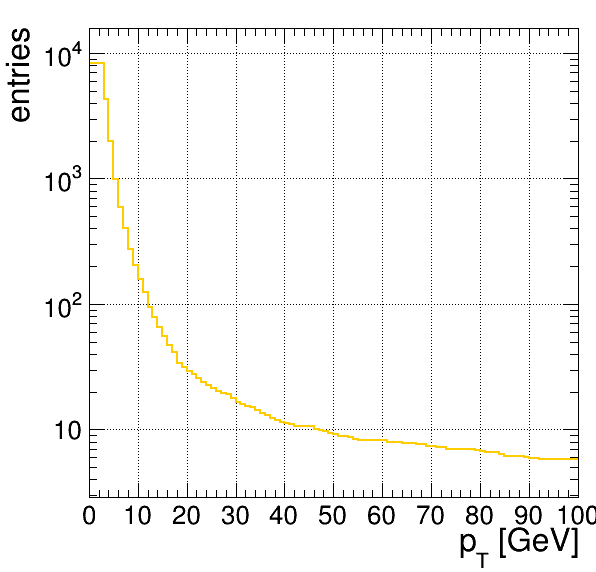

In [17]:
c = ROOT.TCanvas()
rates_hist.Draw("hist")
c.SetLogy()
c.Draw()
print rates_hist.GetBinContent(rates_hist.FindBin(20.))

30.1649169922
22.0335044861
29.1681632996


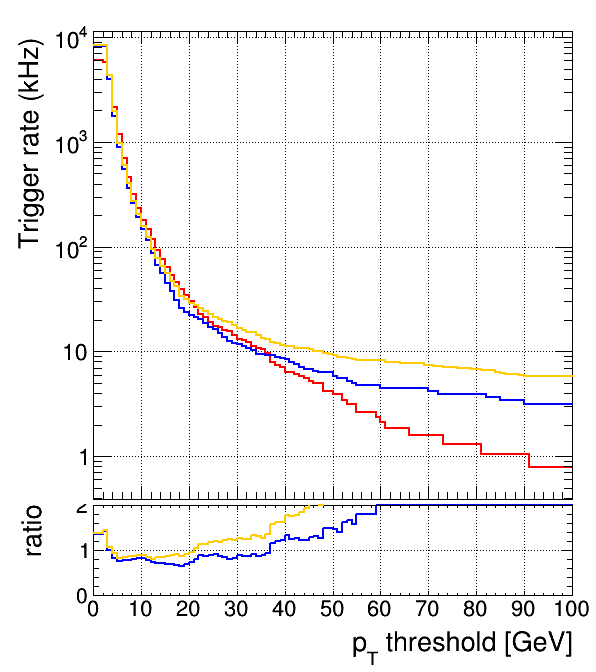

In [18]:
#### Rates ####

infile2 = ROOT.TFile.Open("emtf2023_rate_reduction.root")
#cc1 = infile2.Get("cc1")
denom = infile2.Get("denom")
numer = infile2.Get("numer")
ratio = infile2.Get("ratio")

rates_hist_ratio = rates_hist.Clone("ratio2")
rates_hist_ratio.Divide(rates_hist_ratio, denom, 1, 1, "")

cc1 = ROOT.TCanvas("cc1", "cc1", 600, 700)
cc1.Divide(1,2)
cc1_1 = cc1.GetPad(1)
cc1_1.SetPad(0.01,0.25,0.99,0.99)
cc1_1.SetBottomMargin(0.01)
cc1_1.SetGrid()
cc1_1.SetLogy()
cc1_2 = cc1.GetPad(2)
cc1_2.SetPad(0.01,0.01,0.99,0.25)
cc1_2.SetTopMargin(0.01)
cc1_2.SetBottomMargin(0.43)
cc1_2.SetGrid()

cc1_1.cd()
denom.Draw("hist")
numer.Draw("hist same")
rates_hist.Draw("hist same")
cc1_2.cd()
ratio.Draw("hist same")
rates_hist_ratio.Draw("hist same")
cc1.Draw()

print denom.GetBinContent(denom.FindBin(20.))
print numer.GetBinContent(numer.FindBin(20.))
print rates_hist.GetBinContent(rates_hist.FindBin(20.))